# **Finance Pairs Formation**

# **Import libraries and dataset**

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
import statistics as stats
import plotly.graph_objects as go
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from heapq import nsmallest, nlargest
import matplotlib.pyplot as plt
import seaborn as sns
import more_itertools
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(20,14)})

In [2]:
import sys
# locate the folder which stores the custom package using relative path
sys.path.append('../../../../../src')

import config_snippets as config_snp
import splitting_data as splitting_data
import gatev_distance_method as gatev_dist
import data_transformation_snippets as data_transform_snp
import time_series_analysis_snippets as tsa_snp
import engle_granger_cointegration_method as eg_coint
import johansen_cointegration_method as jj_coint 
import handling_dataframe as hdf
import handling_datetime as hdt


In [3]:
# Path to your config YAML file
config_file_path = "..//..//../config.yaml"

# Load the configuration
config = config_snp.load_config(config_file_path)

if config is not None:
    import ast
    # Access and use the parameters
    split_ratio = config.get("split_ratio")
    
    # Access and convert string to tuple
    # train_period = ast.literal_eval(config.get("train_period"))
    # test_period = ast.literal_eval(config.get("test_period"))
    
    # Get list of df_finance data paths
    lst_df_finance_paths = ast.literal_eval(config.get("paths_df_finance_processed"))
    

In [4]:
# Import data 
path = lst_df_finance_paths[0]
df = pd.read_csv(path)

In [5]:
# Set date as index
df.set_index("date", inplace=True)

In [6]:
df

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_MBB,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,,
2018-06-11,22.219,4.61,2.02,2.50,10.449,4.146,14.971,12.60,5.035,12.177
2018-06-12,22.526,4.45,2.10,2.47,10.156,4.057,14.773,12.80,4.806,12.016
2018-06-13,22.834,4.49,2.15,2.48,10.174,4.102,14.927,12.80,4.909,11.994
2018-06-14,22.219,4.65,2.09,2.49,9.863,4.012,14.332,12.55,4.623,11.444
2018-06-15,22.219,4.69,2.04,2.51,10.139,4.057,14.729,12.40,4.691,11.330
...,...,...,...,...,...,...,...,...,...,...
2020-01-19,11.304,3.88,1.03,2.63,10.016,3.254,9.115,10.60,3.414,8.111
2020-01-20,11.217,3.86,1.04,2.60,10.016,3.210,9.115,10.70,3.414,8.333
2020-01-21,11.174,3.92,1.07,2.64,10.266,3.299,9.115,10.90,3.425,8.722


In [7]:
df = df.dropna()

# **Split data**

In [8]:
# Example: split ratio = 0.7
df_train, df_test = splitting_data.splitting_data_by_ratio(
    df,
    split_ratio=split_ratio
)

In [9]:
# Example of splitting by specified period

# test_train, test_test = splitting_data_by_date(
#     df,
#     train_period = train_period,
#     test_period = test_period
# )

# **Gatev Distance Approach**

In [10]:
df_train

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_MBB,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,,
2018-06-11,22.219,4.61,2.02,2.50,10.449,4.146,14.971,12.60,5.035,12.177
2018-06-12,22.526,4.45,2.10,2.47,10.156,4.057,14.773,12.80,4.806,12.016
2018-06-13,22.834,4.49,2.15,2.48,10.174,4.102,14.927,12.80,4.909,11.994
2018-06-14,22.219,4.65,2.09,2.49,9.863,4.012,14.332,12.55,4.623,11.444
2018-06-15,22.219,4.69,2.04,2.51,10.139,4.057,14.729,12.40,4.691,11.330
...,...,...,...,...,...,...,...,...,...,...
2019-07-25,12.545,5.21,1.39,3.08,9.442,3.076,11.036,11.20,3.519,6.963
2019-07-26,12.442,5.14,1.39,3.08,9.421,3.076,11.059,11.15,3.519,6.945
2019-07-27,12.442,5.14,1.39,3.08,9.421,3.076,11.059,11.15,3.519,6.945


## **Gatev Data Normalization**

In [11]:
df_cum_daily_returns_train = gatev_dist.gatev_data_normalize(df_train)

In [12]:
df_cum_daily_returns_train

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_MBB,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,,
2018-06-12,1.381700e+00,-3.470716,3.960396,-1.2,-2.804096,-2.146647,-1.322557,1.587302,-4.548163,-1.322165
2018-06-13,2.767901e+00,-2.603037,6.435644,-0.8,-2.631831,-1.061264,-0.293902,1.587302,-2.502483,-1.502833
2018-06-14,2.220446e-14,0.867679,3.465347,-0.4,-5.608192,-3.232031,-4.268252,-0.396825,-8.182721,-6.019545
2018-06-15,2.220446e-14,1.735358,0.990099,0.4,-2.966791,-2.146647,-1.616458,-1.587302,-6.832175,-6.955736
2018-06-16,2.220446e-14,1.735358,0.990099,0.4,-2.966791,-2.146647,-1.616458,-1.587302,-6.832175,-6.955736
...,...,...,...,...,...,...,...,...,...,...
2019-07-25,-4.353931e+01,13.015184,-31.188119,23.2,-9.637286,-25.808008,-26.284149,-11.111111,-30.109235,-42.818428
2019-07-26,-4.400288e+01,11.496746,-31.188119,23.2,-9.838262,-25.808008,-26.130519,-11.507937,-30.109235,-42.966248
2019-07-27,-4.400288e+01,11.496746,-31.188119,23.2,-9.838262,-25.808008,-26.130519,-11.507937,-30.109235,-42.966248


## **Gatev Distance Approach Pairs Formation**

In [13]:
gatev_dist.gatev_distance_matrix(df_cum_daily_returns_train)

In [14]:
gatev_pairs, list_result_smallest_dist = gatev_dist.gatev_distance_smallest(
    df=df_cum_daily_returns_train,
    top_values=10
)

In [15]:
for res in list_result_smallest_dist:
    print(res)
    
print(gatev_pairs)

Khoảng cách Euclide của adClose_DXG và adClose_HQC: 180.6
Khoảng cách Euclide của adClose_DXG và adClose_VPB: 193.6
Khoảng cách Euclide của adClose_HQC và adClose_SHB: 147.2
Khoảng cách Euclide của adClose_HQC và adClose_SSI: 183.3
Khoảng cách Euclide của adClose_HQC và adClose_VND: 171.7
Khoảng cách Euclide của adClose_MBB và adClose_SHB: 130.1
Khoảng cách Euclide của adClose_MBB và adClose_SSI: 128.9
Khoảng cách Euclide của adClose_SHB và adClose_SSI: 66.8
Khoảng cách Euclide của adClose_SHB và adClose_VND: 115.2
Khoảng cách Euclide của adClose_SSI và adClose_VND: 105.1
[['adClose_DXG', 'adClose_HQC'], ['adClose_DXG', 'adClose_VPB'], ['adClose_HQC', 'adClose_SHB'], ['adClose_HQC', 'adClose_SSI'], ['adClose_HQC', 'adClose_VND'], ['adClose_MBB', 'adClose_SHB'], ['adClose_MBB', 'adClose_SSI'], ['adClose_SHB', 'adClose_SSI'], ['adClose_SHB', 'adClose_VND'], ['adClose_SSI', 'adClose_VND']]


In [16]:
gatev_pairs

[['adClose_DXG', 'adClose_HQC'],
 ['adClose_DXG', 'adClose_VPB'],
 ['adClose_HQC', 'adClose_SHB'],
 ['adClose_HQC', 'adClose_SSI'],
 ['adClose_HQC', 'adClose_VND'],
 ['adClose_MBB', 'adClose_SHB'],
 ['adClose_MBB', 'adClose_SSI'],
 ['adClose_SHB', 'adClose_SSI'],
 ['adClose_SHB', 'adClose_VND'],
 ['adClose_SSI', 'adClose_VND']]

# **Cointegration Approach**

## **Data Transformation**

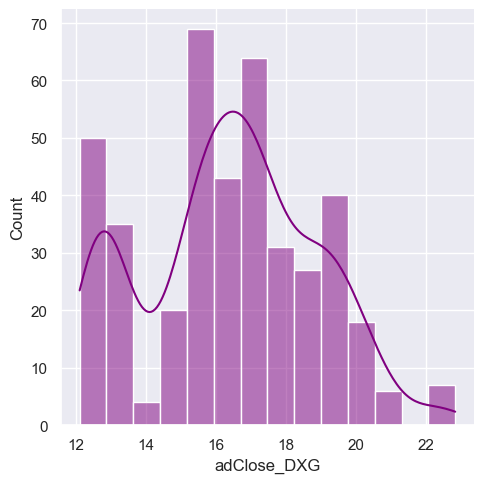

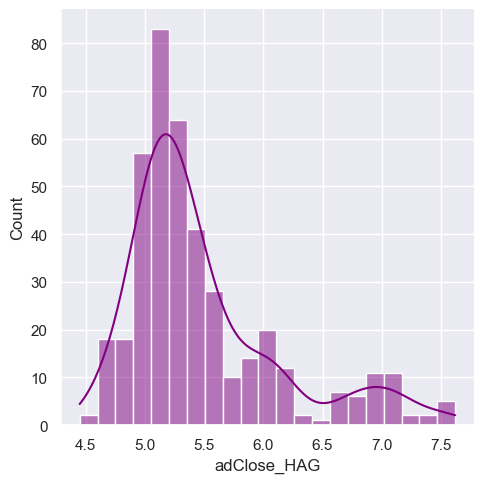

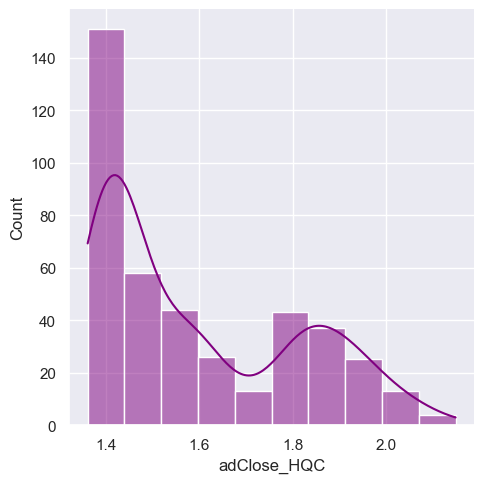

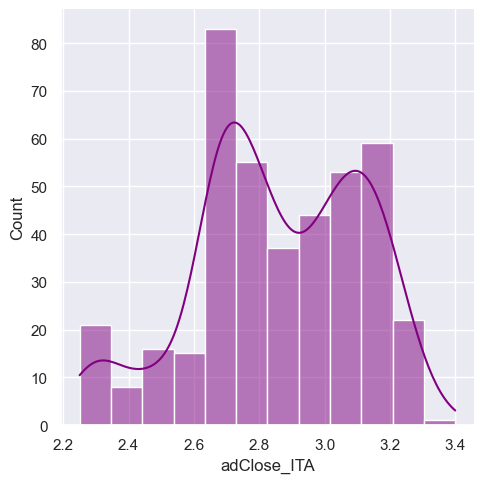

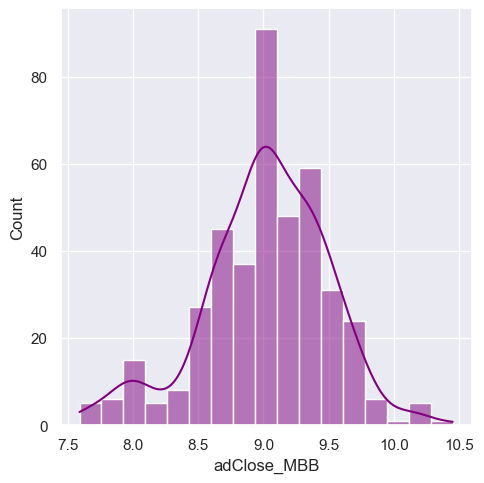

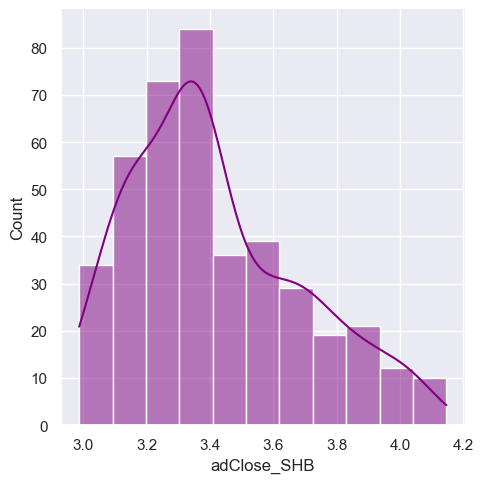

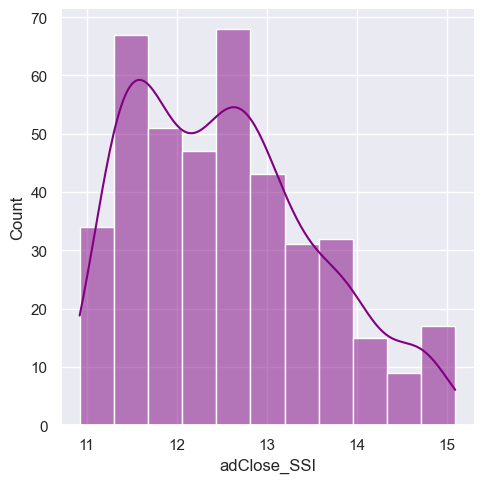

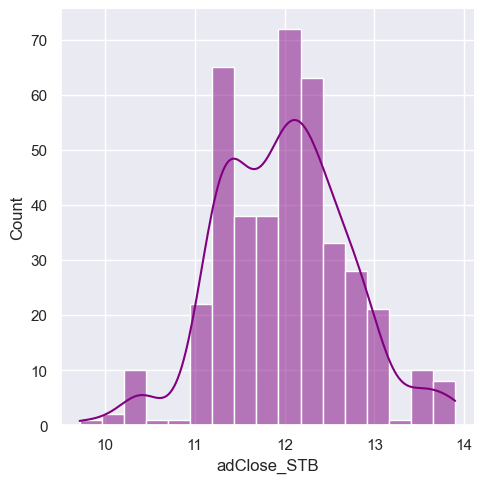

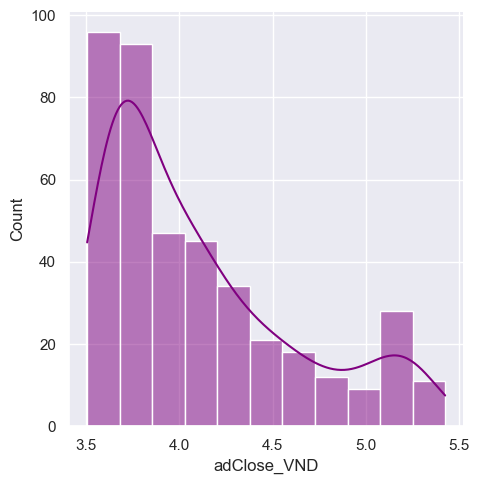

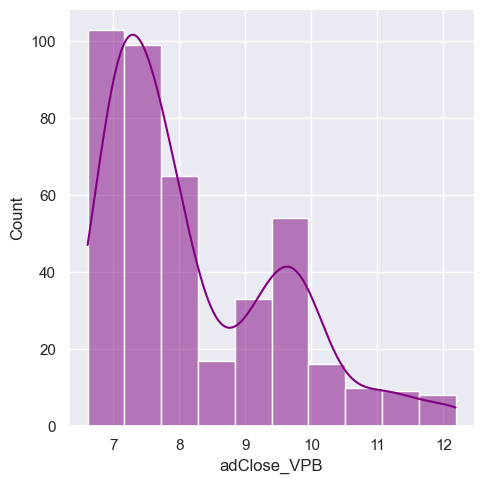

In [17]:
# Visualize distribution of values of each stock
data_transform_snp.dist_stock_visualization(df_train)

In [18]:
# Take natural log transformation of the data  
df_train_transformed = data_transform_snp.df_natural_log_transformed(df_train)

In [19]:
# Visualize distribution of transformed values of each stock
data_transform_snp.dist_stock_visualization(df_train_transformed)

## **Pretesting Stationary**

In [20]:
tsa_snp.find_integration_order(df_train_transformed)

,Column Name,Integration Order
0,adClose_DXG,1
1,adClose_HAG,1
2,adClose_HQC,1
3,adClose_ITA,1
4,adClose_MBB,0
5,adClose_SHB,1
6,adClose_SSI,1
7,adClose_STB,1
8,adClose_VND,1
9,adClose_VPB,1


In [21]:
# Only use time series that have order of integration is 1 
df_order_of_integration_ts = tsa_snp.find_integration_order(df_train_transformed)
lst_non_stationary_ts = df_order_of_integration_ts[
    df_order_of_integration_ts['Integration Order'] == 1
]['Column Name'].tolist()

# Keep those stocks which have order of integration is 1 
df_train_transformed = df_train_transformed[lst_non_stationary_ts]

# Print df
df_train_transformed

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,
2018-06-11,3.100948,1.528228,0.703098,0.916291,1.422144,2.706115,2.533697,1.616414,2.499549
2018-06-12,3.114670,1.492904,0.741937,0.904218,1.400444,2.692801,2.549445,1.569865,2.486239
2018-06-13,3.128251,1.501853,0.765468,0.908259,1.411475,2.703172,2.549445,1.591070,2.484407
2018-06-14,3.100948,1.536867,0.737164,0.912283,1.389290,2.662495,2.529721,1.531044,2.437466
2018-06-15,3.100948,1.545433,0.712950,0.920283,1.400444,2.689818,2.517696,1.545646,2.427454
...,...,...,...,...,...,...,...,...,...
2019-07-25,2.529322,1.650580,0.329304,1.124930,1.123630,2.401163,2.415914,1.258177,1.940610
2019-07-26,2.521078,1.637053,0.329304,1.124930,1.123630,2.403245,2.411439,1.258177,1.938022
2019-07-27,2.521078,1.637053,0.329304,1.124930,1.123630,2.403245,2.411439,1.258177,1.938022


## **Engle - Grange Method**

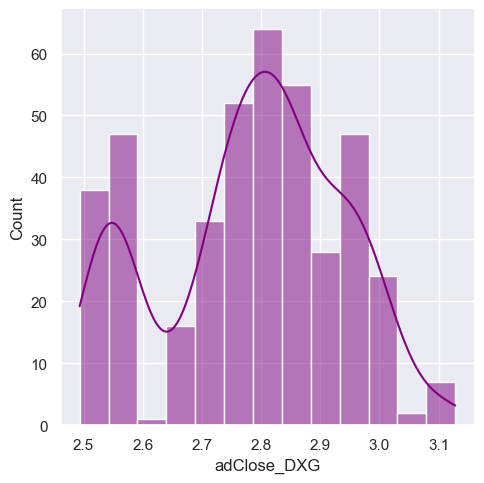

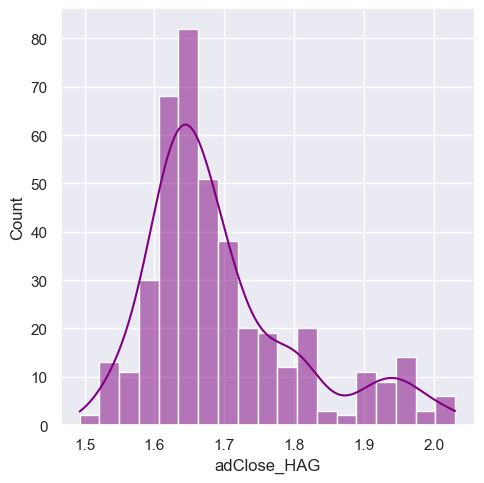

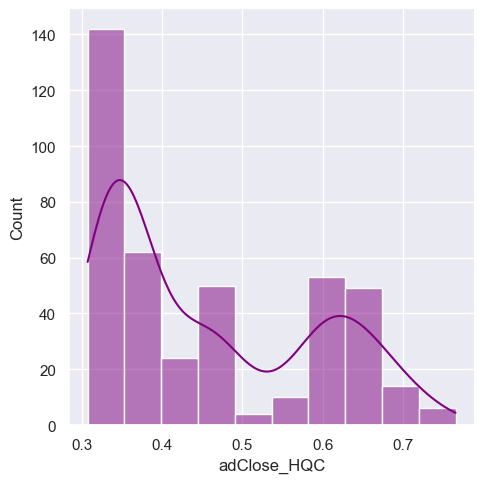

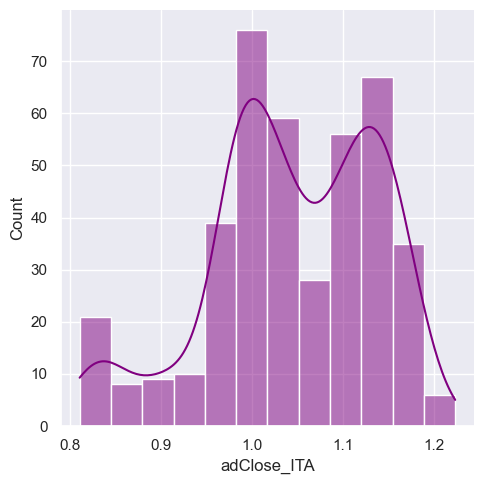

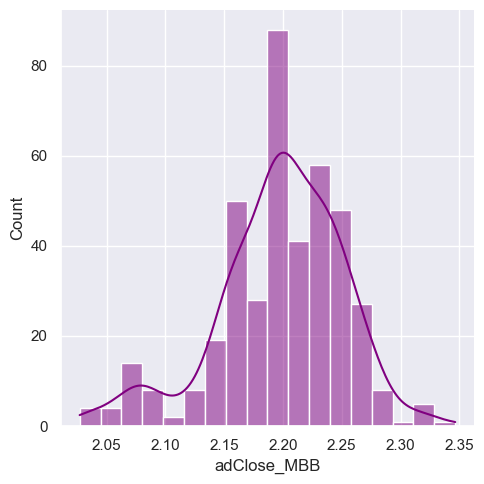

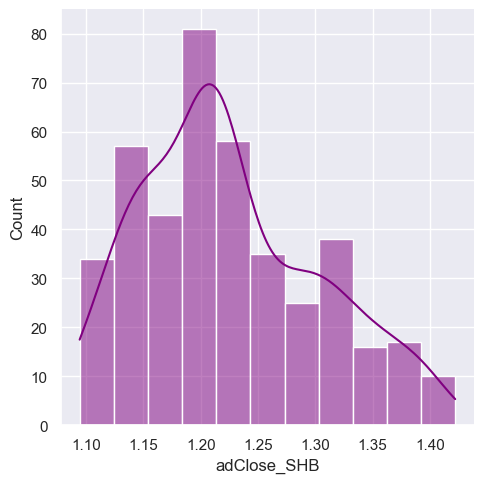

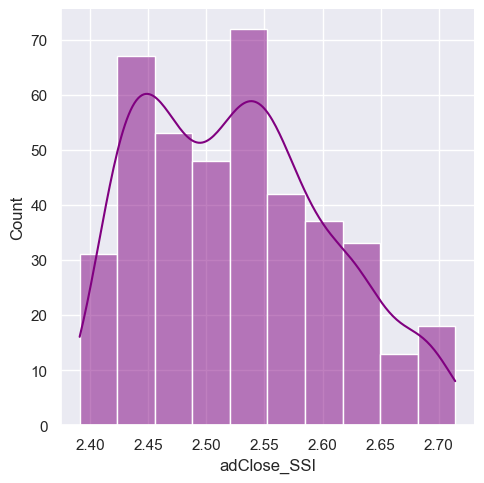

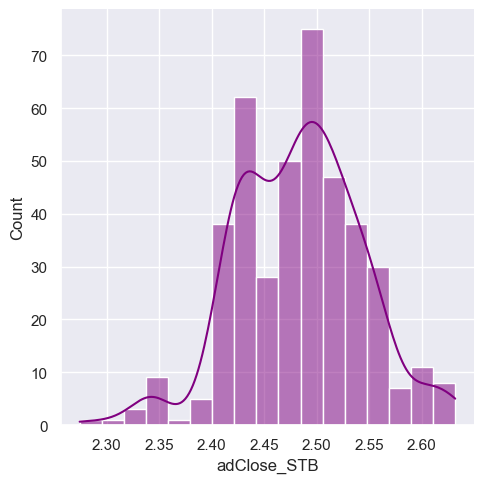

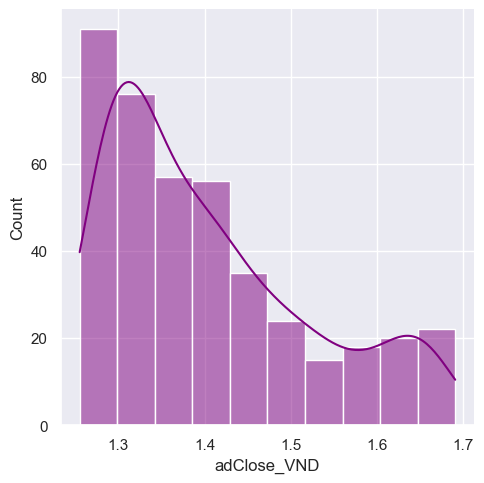

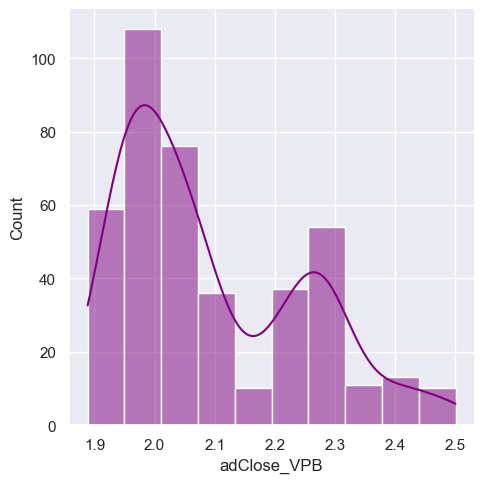

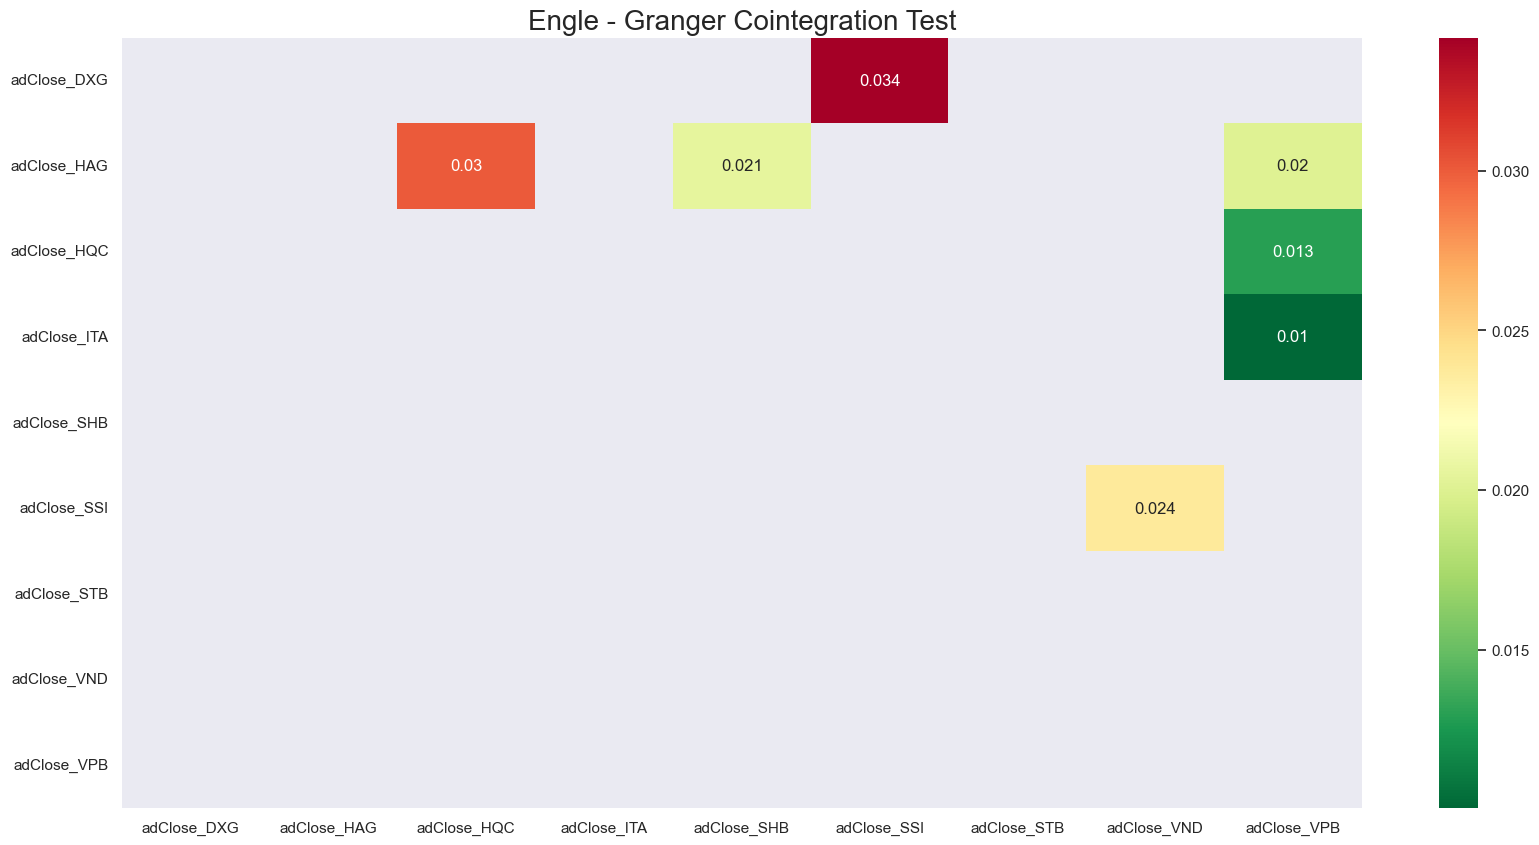

In [22]:
score_matrix, pvalue_matrix, eg_pairs = eg_coint.find_cointegrated_pairs(df_train_transformed)

In [23]:
eg_pairs 

[['adClose_DXG', 'adClose_SSI'],
 ['adClose_HAG', 'adClose_HQC'],
 ['adClose_HAG', 'adClose_SHB'],
 ['adClose_HAG', 'adClose_VPB'],
 ['adClose_HQC', 'adClose_VPB'],
 ['adClose_ITA', 'adClose_VPB'],
 ['adClose_SSI', 'adClose_VND']]

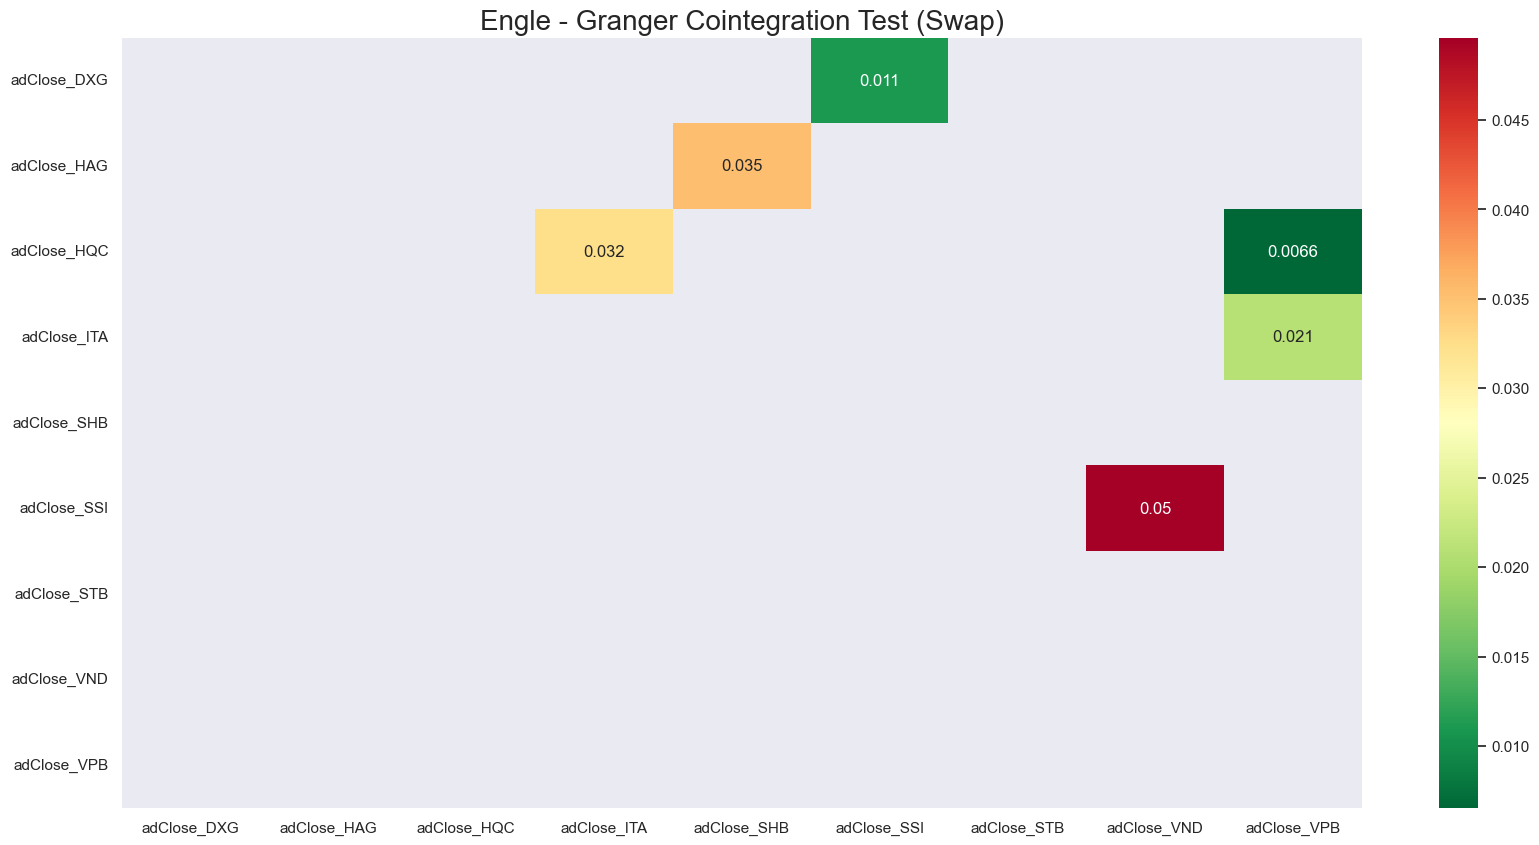

In [24]:
scores_swap, pvalues_swap, eg_pairs_swap = eg_coint.find_cointegrated_pairs_swap(df_train_transformed)

In [25]:
eg_pairs_swap

[['adClose_DXG', 'adClose_SSI'],
 ['adClose_HAG', 'adClose_SHB'],
 ['adClose_HQC', 'adClose_ITA'],
 ['adClose_HQC', 'adClose_VPB'],
 ['adClose_ITA', 'adClose_VPB'],
 ['adClose_SSI', 'adClose_VND']]

## **Johansen Method**

In [26]:
johansen_pairs = jj_coint.johansen_test(df_train_transformed)

In [27]:
johansen_pairs

[['adClose_DXG', 'adClose_HAG'],
 ['adClose_HAG', 'adClose_HQC'],
 ['adClose_HAG', 'adClose_ITA'],
 ['adClose_HAG', 'adClose_SHB'],
 ['adClose_HAG', 'adClose_SSI'],
 ['adClose_HAG', 'adClose_STB'],
 ['adClose_HAG', 'adClose_VND'],
 ['adClose_HAG', 'adClose_VPB'],
 ['adClose_HQC', 'adClose_ITA'],
 ['adClose_HQC', 'adClose_VPB'],
 ['adClose_ITA', 'adClose_SHB'],
 ['adClose_ITA', 'adClose_VPB'],
 ['adClose_SSI', 'adClose_VND'],
 ['adClose_STB', 'adClose_VND']]

# **Result Summary**

In [28]:
df_pairs_formation_train = hdf.pairs_formation_result_summary(
    gatev_pairs,
    eg_pairs,
    eg_pairs_swap,
    johansen_pairs
)

In [29]:
df_pairs_formation_train

,Stock A,Stock B,Gatev Pairs,EG Pairs,EG Pairs Swap,Johansen Pairs,Count
0,adClose_DXG,adClose_HAG,,,,x,1
1,adClose_DXG,adClose_HQC,x,,,,1
2,adClose_DXG,adClose_SSI,,x,x,,2
3,adClose_DXG,adClose_VPB,x,,,,1
4,adClose_HAG,adClose_HQC,,x,,x,2
5,adClose_HAG,adClose_ITA,,,,x,1
6,adClose_HAG,adClose_SHB,,x,x,x,3
7,adClose_HAG,adClose_SSI,,,,x,1
8,adClose_HAG,adClose_STB,,,,x,1
9,adClose_HAG,adClose_VND,,,,x,1


In [30]:
df_pairs_formation_train.to_csv(
    f"..//..//..//..//..//results//pairs_formation//finance//finance_pairs_formation_first_period_{hdt.today_date_to_digits()}.csv"
    )